# Perfil de usuário (log)

Neste Notebook, procura-se possíveis grupos de perfil de usuários baseados features extraídos do arquivo anonimized_logs.csv.


*   EDA
*   Clusterização
*   Relacionar os clusters com o modelo de score


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import cmath

# 1 Carregar os Dados

### **log_data_df**: *anonimized_logs.csv* - tabela contendo todos os registros de log dos usuários

### **user_score_vidLen_df**: *alunos.csv* -  tabela contendo os scores* e total de tempo de vídeo assistido pelos alunos


**Verifar o notebook xxxx para mais detalhes sobre o cálculo desse score*




In [3]:
log_data_df = pd.read_csv("/content/drive/My Drive/Disciplinas/Lab avancado de ciencias de dados/new_data/anonimized_logs.csv") 
log_data_df.head()

,user_uuid,moment,kind,iterable_uuid
0,57928,2016-09-12,EXERCISE_ANSWERED,2918d775-73e8-4c33-a3b7-5f0726bbe3ca
1,73719,2016-09-12,EXERCISE_ANSWERED,1315cdde-14e1-412d-bc3b-5da04b7aa44a
2,38957,2016-09-12,EXERCISE_ANSWERED,2ec53649-0eae-4114-b21f-ad72d448180b
3,59788,2016-09-12,EXERCISE_ANSWERED,ad5ae7b6-918f-4dfe-8680-db2928fe732c
4,73719,2016-09-12,EXERCISE_ANSWERED,7e08ee37-3eb6-4412-a6dd-d01f5619d2a2


In [4]:
users_score_vidLen_df = pd.read_csv("/content/drive/My Drive/Disciplinas/Lab avancado de ciencias de dados/new_data/alunos.csv") 
users_score_vidLen_df.head()

,Unnamed: 0,user_uuid,score,duration
0,0,53284,5.514413,981
1,56,27744,8.865532,151
2,212,16791,3.137688,85
3,254,57928,4.885787,192
4,267,25141,14.927590,601


# 2 Análise exploratória dos Dados




In [5]:
print(log_data_df.info())
print(f'Há nesse conjunto {len(log_data_df.index)} registros de log')
print(" ")
print("=============================================================")
print("=============================================================")
print(" ")
print(users_score_vidLen_df.info())
print(f'Há nesse conjunto {len(users_score_vidLen_df.index)} registros de log')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18533471 entries, 0 to 18533470
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_uuid      int64 
 1   moment         object
 2   kind           object
 3   iterable_uuid  object
dtypes: int64(1), object(3)
memory usage: 565.6+ MB
None
Há nesse conjunto 18533471 registros de log
 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1007 non-null   int64  
 1   user_uuid   1007 non-null   int64  
 2   score       1007 non-null   float64
 3   duration    1007 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 31.6 KB
None
Há nesse conjunto 1007 registros de log


In [6]:
print(log_data_df.kind.value_counts())

EXERCISE_ANSWERED      18000612
COURSE_FINISHED          426290
FORUM_POSTED              67213
FORUM_SOLVED              13963
CAREER_FINISHED           12514
DEGREE_FINISHED            9247
SUGGESTION_APPROVED        3558
PROJECT_APPROVED             74
Name: kind, dtype: int64


Há log de 73601 usuários distintos


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


entre 1 a 10 logs           8317
entre 11 a 100 logs        25599
entre 101 a 1000 logs      36690
entre 1001 a 13753 logs     2995
dtype: int64


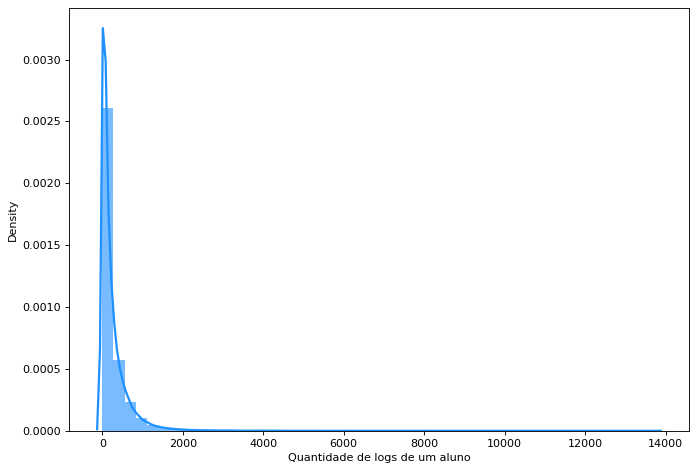

In [7]:
uniqueUserLogCount = log_data_df.user_uuid.value_counts()
print(f'Há log de {uniqueUserLogCount.shape[0]} usuários distintos')

plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(uniqueUserLogCount.values, color="dodgerblue", axlabel="Quantidade de logs de um aluno",label="Compact", **kwargs)

temp_count=np.array([uniqueUserLogCount.values[uniqueUserLogCount.values<=10].shape[0],
                     uniqueUserLogCount.values[uniqueUserLogCount.values<=100].shape[0],
                     uniqueUserLogCount.values[uniqueUserLogCount.values<=1000].shape[0],
                     uniqueUserLogCount.values[uniqueUserLogCount.values<=13753].shape[0],
                     ])

log_distribution=np.array(
    [temp_count[0],
     temp_count[1]-temp_count[0],
     temp_count[2]-temp_count[1],
     temp_count[3]-temp_count[2],
    ]
)
print(pd.Series(log_distribution, index =["entre 1 a 10 logs","entre 11 a 100 logs","entre 101 a 1000 logs","entre 1001 a 13753 logs"])) 

In [8]:
# função auxiliar para calcular a diferença em dias de datas no formato de aaaa-mm-dd (string)
def getDateDiff(date1, date2):
  date1_parsed = date1.split('-')
  date2_parsed = date2.split('-')
  date1_obj = datetime.datetime(int(date1_parsed[0]), int(date1_parsed[1]),int(date1_parsed[2]))
  date2_obj = datetime.datetime(int(date2_parsed[0]), int(date2_parsed[1]), int(date2_parsed[2]))
  return((date2_obj-date1_obj).days)

In [9]:
# função para calcular e imprimir valores máximos, mínimos, média, media e devio padrão de um conjunto de dados numérico
def basicStatistic(data):
  st = np.array([data.max(), data.min(), data.mean(), np.median(data), np.std(data)])
  sr = pd.Series(st, index =["max","min","média","mediano","des. pad."])
  print(sr) 

In [10]:
minimum_log_limit = 400 

size = uniqueUserLogCount.values[uniqueUserLogCount.values > minimum_log_limit].shape[0]

users =  uniqueUserLogCount.index[:size]

log_density = np.zeros((size))
daily_log_density = np.zeros((size))
interval = np.zeros((size))
log_counts = uniqueUserLogCount.values[:size]

for i in range (size):
  is_user =  log_data_df['user_uuid']==users[i]
  logData_user = log_data_df[is_user]
  sorted_logData_user = logData_user.sort_values(by = 'moment')
  dates = sorted_logData_user['moment'].values

  interval[i]=(getDateDiff(dates[0],dates[dates.shape[0]-1])+1)
  log_density[i]=sorted_logData_user.moment.value_counts().index.shape[0] / interval[i]
  daily_log_density[i] = sorted_logData_user.moment.value_counts().mean()


absolute_log_counts = np.zeros((size, int(interval.max())))

for i in range (size):
  is_user =  log_data_df['user_uuid']==users[i]
  logData_user = log_data_df[is_user]
  sorted_logData_user = logData_user.sort_values(by = 'moment')
  dates = sorted_logData_user['moment'].values
  absolute_log_counts[i,0] = 1
  pointer = 0
  for j in range (1,dates.shape[0]):
    date_diff = getDateDiff(dates[j-1],dates[j])
    absolute_log_counts[i,pointer+date_diff] = absolute_log_counts[i,pointer+date_diff]+1
    pointer = pointer+date_diff

max          1446.000000
min             3.000000
média         634.255055
mediano       550.000000
des. pad.     396.877655
dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


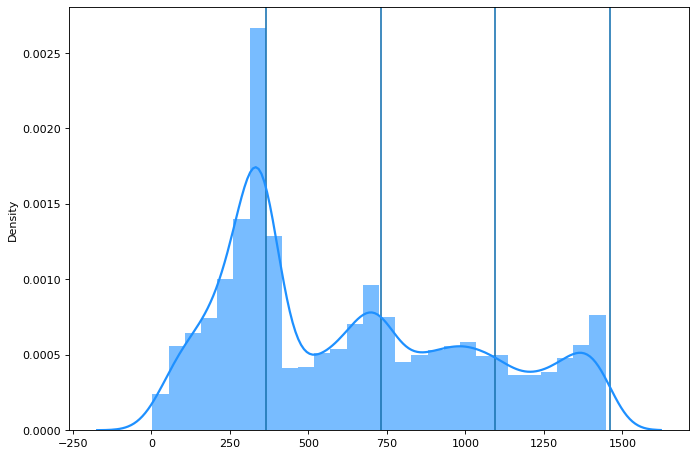

In [11]:
# analisando os intervalos
basicStatistic(interval)
plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.axvline(365)
plt.axvline(730)
plt.axvline(1095)
plt.axvline(1460)
sns.distplot(interval, color="dodgerblue", label="Compact", **kwargs)

max          1.000000
min          0.014433
média        0.187913
mediano      0.151442
des. pad.    0.136937
dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


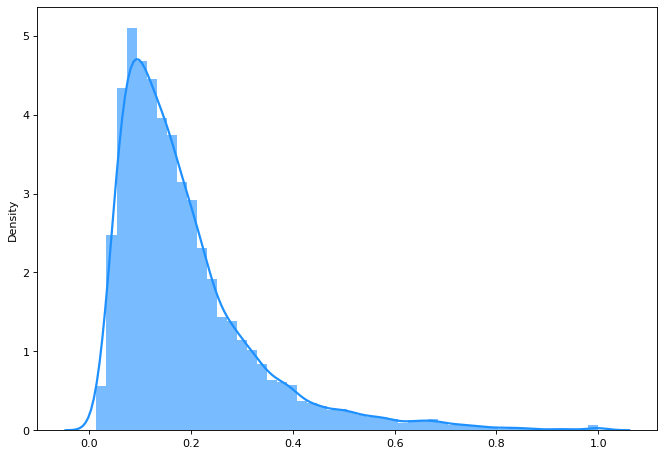

In [12]:
# analisando os quantidade dias de atividade por intervalo total
basicStatistic(log_density)
plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(log_density, color="dodgerblue", label="Compact", **kwargs)

max          567.000000
min            2.064516
média         11.414086
mediano        8.960000
des. pad.     11.598739
dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


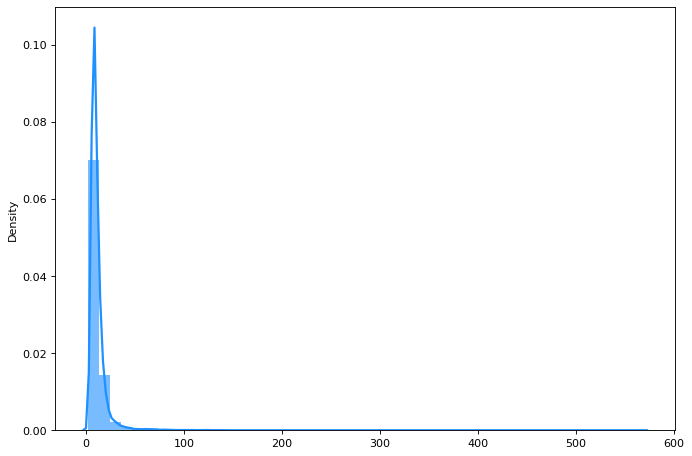

In [13]:
# analisando os quantidade log por dias de atividade
basicStatistic(daily_log_density)
plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(daily_log_density, color="dodgerblue", label="Compact", **kwargs)

max          13753.000000
min            401.000000
média          829.797365
mediano        648.000000
des. pad.      631.688774
dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


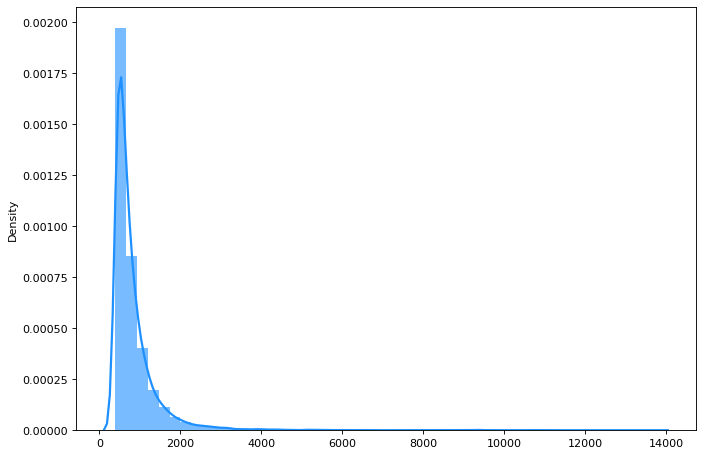

In [14]:
# analisando os quantidade de logs por usuários
basicStatistic(log_counts)
plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(log_counts, color="dodgerblue", label="Compact", **kwargs)

In [16]:
df = pd.DataFrame({'interval': interval})
df['log_density'] = log_density
df['daily_log_density'] = daily_log_density
df['log_counts'] = log_counts

df.corr()

,interval,log_density,daily_log_density,log_counts
interval,1.000000,-0.558981,-0.219037,0.214410
log_density,-0.558981,1.000000,0.106627,0.150637
daily_log_density,-0.219037,0.106627,1.000000,0.286644
log_counts,0.214410,0.150637,0.286644,1.000000


In [17]:
colors=np.log(log_counts)
area = np.pi*10
cmap = sns.cubehelix_palette(dark=0, light=0.7,as_cmap=True)

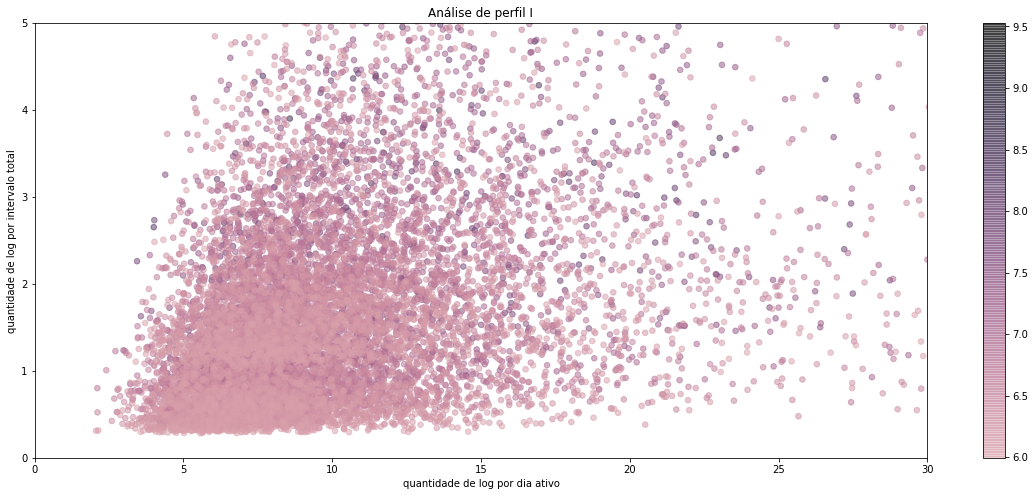

In [18]:
#maior correlação
plt.figure(figsize=(20,8))
sc =plt.scatter(daily_log_density, np.divide(log_counts,interval), s=area, c=colors, alpha=0.5,cmap=cmap)
plt.xlim(0, 30)
plt.ylim(0, 5)

plt.title('Análise de perfil I')
plt.xlabel('quantidade de log por dia ativo')
plt.ylabel('quantidade de log por intervalo total')
plt.colorbar(sc)
plt.show()

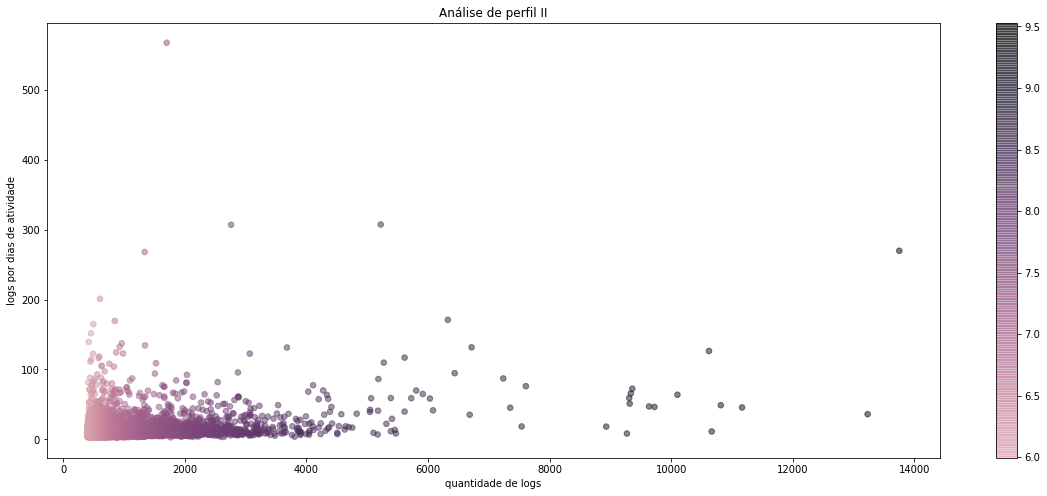

In [19]:
#2a maior correlação
plt.figure(figsize=(20,8))
sc =plt.scatter(log_counts,daily_log_density, s=area, c=colors, alpha=0.5,cmap=cmap)


plt.title('Análise de perfil II')
plt.xlabel('quantidade de logs')
plt.ylabel('logs por dias de atividade')
plt.colorbar(sc)
plt.show()

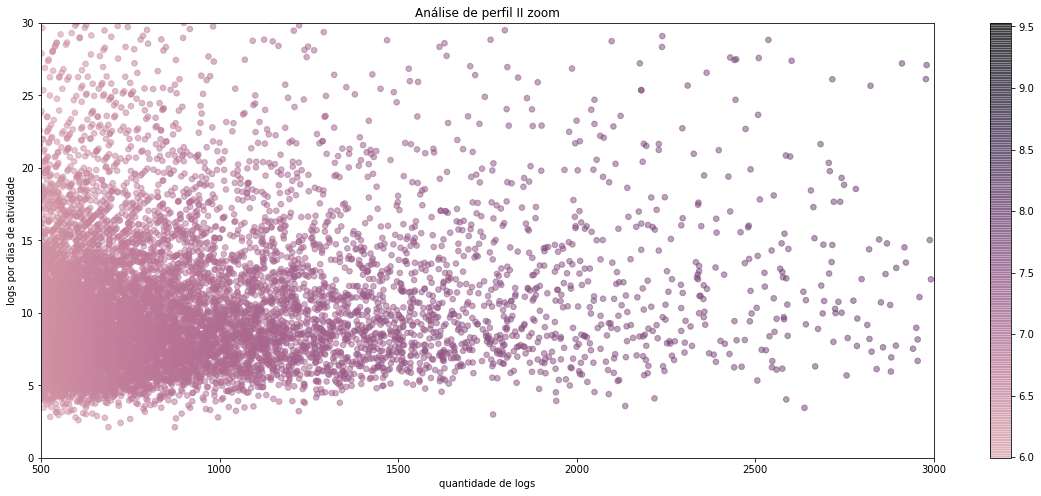

In [20]:
#2a maior correlação
plt.figure(figsize=(20,8))
sc =plt.scatter(log_counts,daily_log_density, s=area, c=colors, alpha=0.5,cmap=cmap)

plt.xlim(500, 3000)
plt.ylim(0, 30)
plt.title('Análise de perfil II zoom')
plt.xlabel('quantidade de logs')
plt.ylabel('logs por dias de atividade')
plt.colorbar(sc)
plt.show()

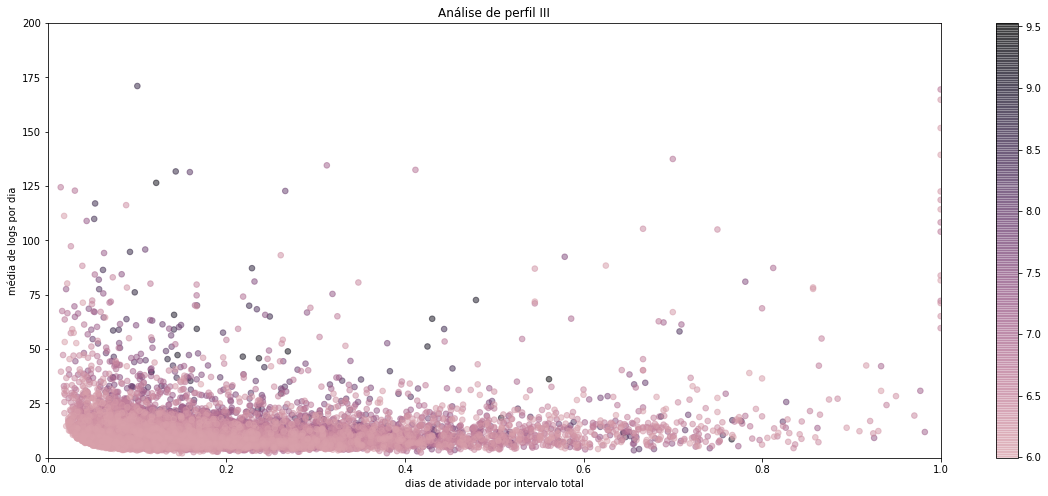

In [21]:
plt.figure(figsize=(20,8))
sc =plt.scatter(log_density, daily_log_density, s=area, c=colors, alpha=0.5,cmap=cmap)

plt.xlim(0, 1)
plt.ylim(0, 200)
plt.title('Análise de perfil III')
plt.xlabel('dias de atividade por intervalo total')
plt.ylabel('média de logs por dia')
plt.colorbar(sc)
plt.show()

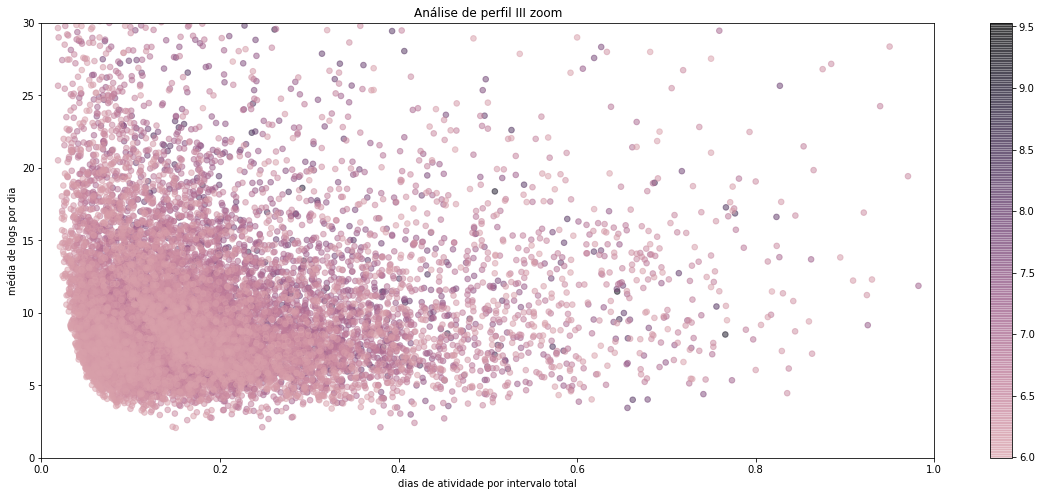

In [22]:
plt.figure(figsize=(20,8))
sc =plt.scatter(log_density, daily_log_density, s=area, c=colors, alpha=0.5,cmap=cmap)

plt.xlim(0, 1)
plt.ylim(0, 30)
plt.title('Análise de perfil III zoom')
plt.xlabel('dias de atividade por intervalo total')
plt.ylabel('média de logs por dia')
plt.colorbar(sc)
plt.show()

# Clusterização por K-means com transformada de fourier discreta

<BarContainer object of 1446 artists>

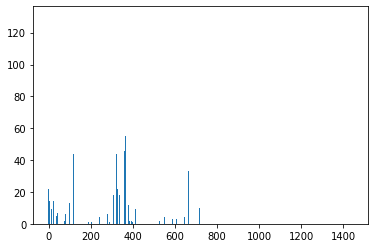

In [23]:
# sample de uma distribuição
plt.bar(range(0,absolute_log_counts.shape[1]),absolute_log_counts[200])

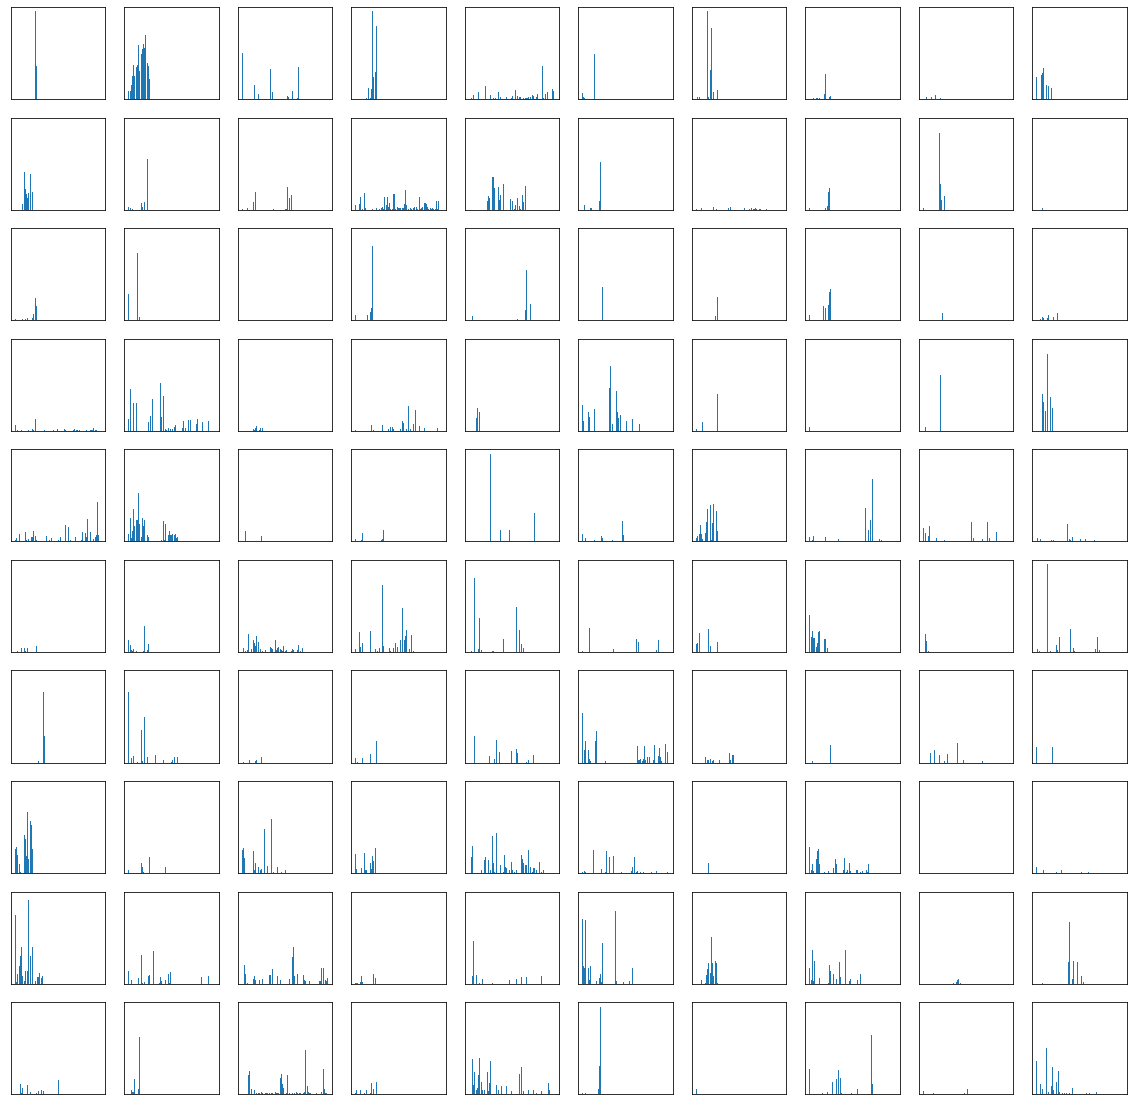

In [24]:
# sample das 100 primeiras distribuições
maxplotNumber = 100
count = 0
subplot_args = {'nrows': 10, 'ncols':10, 'figsize':(20,20),
                'subplot_kw': {'xticks':[],'yticks':[]}}
f, ax = plt.subplots(**subplot_args)
for i in range (maxplotNumber):
  ax.flatten()[i].bar(range(0,absolute_log_counts.shape[1]),absolute_log_counts[i,:])

## Pela distribuição do intervalo, temos muitos alunos que permaneceram pelo menos 1 anos na plataforma. Então vamos truncar todos os usuários no dia 366 (analyzed_days).

Depois da transformada, vamos testar duas métricas para o K-means: decompor o número complexo em parte real e parte imaginária (rf_absolute_log_counts); decompor o número complexo em módulo e fase (rf_absolute_log_counts_polar)


# Tranforamda de Fourier Discreta

In [25]:
analyzed_days = 366
fourier_absolute_log_counts = np.fft.rfft(absolute_log_counts[:,:analyzed_days])

fourier_size =fourier_absolute_log_counts.shape[1]
rf_absolute_log_counts = np.zeros((fourier_absolute_log_counts.shape[0],fourier_size*2))
rf_absolute_log_counts_polar = np.zeros((fourier_absolute_log_counts.shape[0],fourier_size*2))

print(fourier_absolute_log_counts.shape)
print(rf_absolute_log_counts.shape)
for i in range (fourier_absolute_log_counts.shape[0]):
  for j in range (fourier_absolute_log_counts.shape[1]):
    tempPolar = cmath.polar(fourier_absolute_log_counts[i,j])
    rf_absolute_log_counts_polar[i,j] = tempPolar[0]
    rf_absolute_log_counts_polar[i,fourier_absolute_log_counts.shape[1]+j] = tempPolar[1] 
  rf_absolute_log_counts[i,:fourier_size] = fourier_absolute_log_counts[i].real
  rf_absolute_log_counts[i,fourier_size:] = fourier_absolute_log_counts[i].imag


(14193, 184)
(14193, 368)


In [26]:
log_counts_limited = np.sum(absolute_log_counts[:,:366], axis=1)
log_counts_limited.shape

(14193,)

# K-means

In [27]:
n_clusters = 8
kmeans_decomposed_complex = KMeans(n_clusters=n_clusters, random_state=3).fit(rf_absolute_log_counts)
Y_decomposed_complex = kmeans_decomposed_complex.labels_

kmeans_decomposed_polar = KMeans(n_clusters=n_clusters, random_state=0).fit(rf_absolute_log_counts_polar)
Y_decomposed_polar = kmeans_decomposed_polar.labels_

In [28]:
print(Y_decomposed_complex.shape)
print(Y_decomposed_polar.shape)

(14193,)
(14193,)


In [29]:
centers_decomposed_complex = kmeans_decomposed_complex.cluster_centers_
centers_decomposed_polar = kmeans_decomposed_polar.cluster_centers_

In [30]:
centers_decomposed_complex.shape
centers_decomposed_polar.shape

(8, 368)

In [31]:
center_complex = np.zeros(fourier_absolute_log_counts.shape,dtype=np.complex_)
center_complex_polar = np.zeros(fourier_absolute_log_counts.shape,dtype=np.complex_)

In [32]:
centers_decomposed_complex.shape[1]/2

184.0

In [33]:
center_complex = centers_decomposed_complex[:,:int(centers_decomposed_complex.shape[1]/2)] + 1j * centers_decomposed_complex[:,int(centers_decomposed_complex.shape[1]/2):]

for i in range(centers_decomposed_polar.shape[0]):
  for j in range (int(centers_decomposed_polar.shape[1]/2)):
    center_complex_polar[i,j] = cmath.rect(centers_decomposed_polar[i,j],centers_decomposed_polar[i,int(centers_decomposed_polar.shape[1]/2)+j])

# Converter os centroides de volta para dimensão do tempo

In [34]:
center_temporal = np.fft.irfft(center_complex)
center_temporal_polar = np.fft.irfft(center_complex_polar)

In [35]:
center_temporal.shape
center_temporal_polar.shape

(14193, 366)

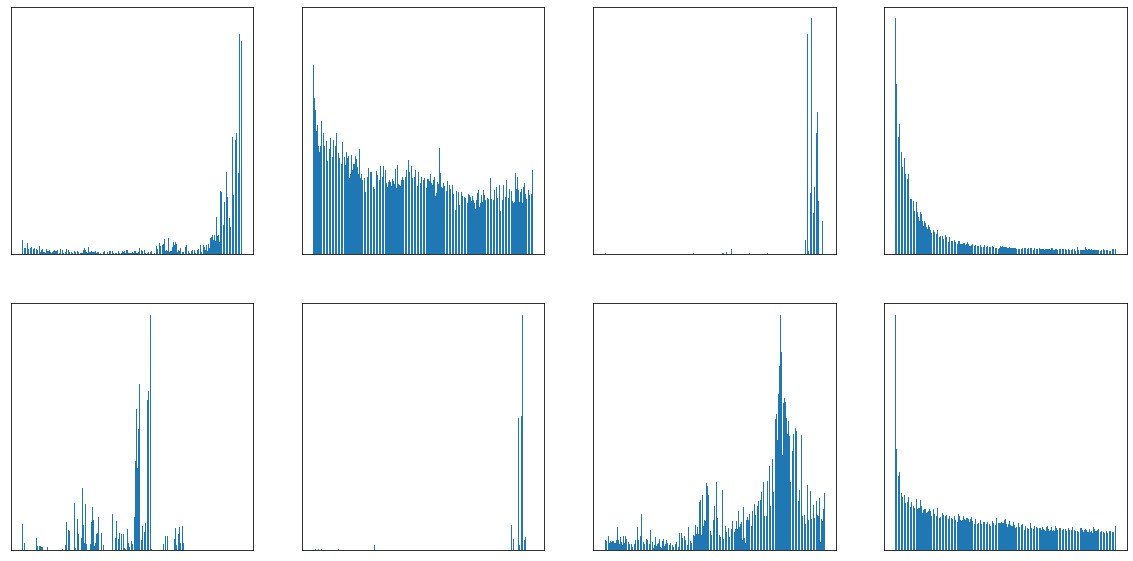

In [36]:
# clusters de decomposição real-imaginário
nrows = n_clusters//4
if (n_clusters%4 != 0):
  nrows=nrows+1
count = 0
subplot_args = {'nrows': nrows, 'ncols':4, 'figsize':(20,10),
                'subplot_kw': {'xticks':[],'yticks':[]}}
f, ax = plt.subplots(**subplot_args)
for i in range (n_clusters):
    ax.flatten()[i].bar(range(0,center_temporal.shape[1]),center_temporal[i,:])

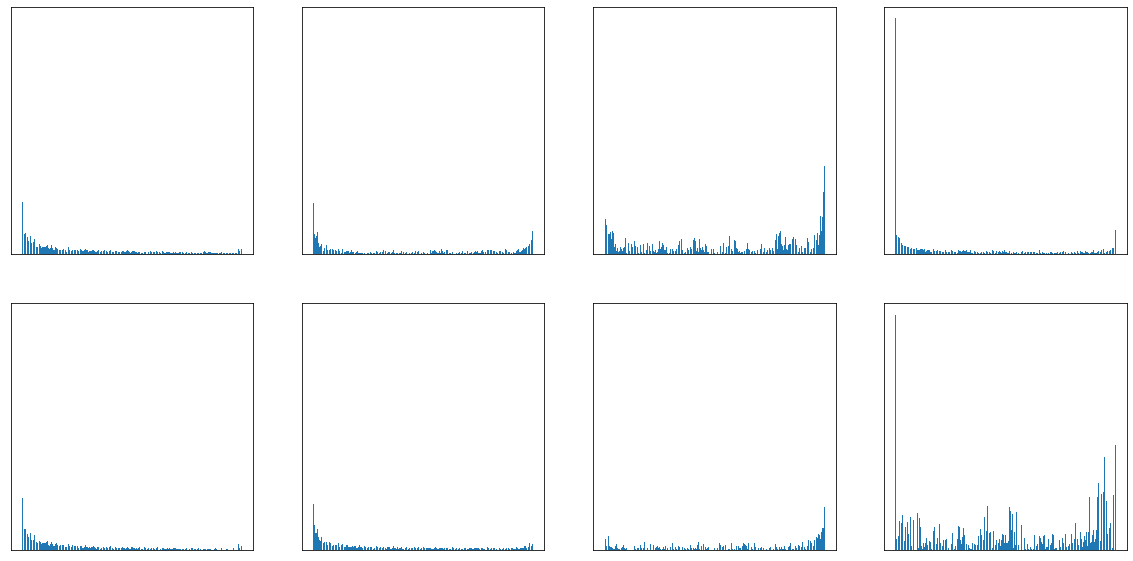

In [37]:
# clusters de decomposição polar
nrows = n_clusters//4
if (n_clusters%4 != 0):
  nrows=nrows+1
count = 0
subplot_args = {'nrows': nrows, 'ncols':4, 'figsize':(20,10),
                'subplot_kw': {'xticks':[],'yticks':[]}}
f, ax = plt.subplots(**subplot_args)

for i in range (n_clusters):
    ax.flatten()[i].bar(range(0,center_temporal_polar.shape[1]),abs(center_temporal_polar[i,:]))

In [38]:
# clusters de decomposição real-imaginário
for i in range(n_clusters):
  print("cluster % s"% i)
  print((Y_decomposed_complex==i).sum())
  print((Y_decomposed_complex==i).sum()*100/Y_decomposed_complex.shape[0],'%')
  print(" ")

cluster 0
34
0.23955471006834356 %
 
cluster 1
1011
7.1232297611498625 %
 
cluster 2
1
0.007045726766715987 %
 
cluster 3
2894
20.390333262876066 %
 
cluster 4
2
0.014091453533431974 %
 
cluster 5
1
0.007045726766715987 %
 
cluster 6
13
0.09159444796730783 %
 
cluster 7
10237
72.12710491087155 %
 


In [39]:
# clusters de decomposição polar
for i in range(n_clusters):
  print("cluster % s"% i)
  print((Y_decomposed_polar==i).sum())
  print((Y_decomposed_polar==i).sum()*100/Y_decomposed_polar.shape[0],'%')
  print(" ")

cluster 0
2398
16.895652786584936 %
 
cluster 1
164
1.1554991897414217 %
 
cluster 2
15
0.1056859015007398 %
 
cluster 3
651
4.5867681251321075 %
 
cluster 4
6119
43.11280208553512 %
 
cluster 5
4797
33.79835129993659 %
 
cluster 6
45
0.31705770450221943 %
 
cluster 7
4
0.02818290706686395 %
 


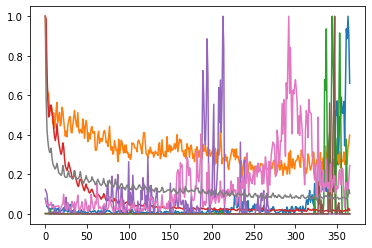

In [42]:
# comparação dos clusters (real-imaginário) normalizados
plt.plot(range(0,center_temporal.shape[1]),center_temporal[0]/center_temporal[0].max())
plt.plot(range(0,center_temporal.shape[1]),center_temporal[1]/center_temporal[1].max())
plt.plot(range(0,center_temporal.shape[1]),center_temporal[2]/center_temporal[2].max())
plt.plot(range(0,center_temporal.shape[1]),center_temporal[3]/center_temporal[3].max())
plt.plot(range(0,center_temporal.shape[1]),center_temporal[4]/center_temporal[4].max())
plt.plot(range(0,center_temporal.shape[1]),center_temporal[5]/center_temporal[5].max())
plt.plot(range(0,center_temporal.shape[1]),center_temporal[6]/center_temporal[6].max())
plt.plot(range(0,center_temporal.shape[1]),center_temporal[7]/center_temporal[7].max())

In [ ]:
gabriel_users = pd.read_csv("/content/drive/My Drive/Disciplinas/Lab avancado de ciencias de dados/scores.csv") 
gabriel_users.head()

,user_uuid,score
0,53284,5.514413
1,27744,8.865532
2,16791,3.137688
3,57928,4.885787
4,25141,14.927590


# Relacionar os clusters acima com resultados do modelo de score

In [44]:
tr= 0
for i in range (users_score_vidLen_df.shape[0]):
  if(users_score_vidLen_df['user_uuid'][i] in users):
    tr=tr+1
print("Quantidade de alunos que estão em ambas as tabelas:")
print(tr)

Quantidade de alunos que estão em ambas as tabelas:
540


In [46]:
intersection_users = np.zeros((tr))
intersection_users_category = np.zeros((tr))
intersection_users_score = np.zeros((tr))
tr_count=0
for i in range (users_score_vidLen_df['user_uuid'].shape[0]):
  for j in range (users.shape[0]):
    if (users_score_vidLen_df['user_uuid'][i] == users[j]):
      intersection_users[tr_count] = users_score_vidLen_df['user_uuid'][i]
      intersection_users_category[tr_count] = Y_decomposed_complex[j]
      intersection_users_score[tr_count] = users_score_vidLen_df['score'][i]
      tr_count= tr_count+1
      break

In [47]:
unique, counts = np.unique(intersection_users_category, return_counts=True)
cat_count_dict = dict(zip(unique, counts))
dict(zip(unique, counts))

{1.0: 46, 3.0: 106, 6.0: 1, 7.0: 387}

In [49]:
cat_1 = np.asarray([]) 
cat_3 = np.asarray([]) 
cat_6 = np.asarray([])  
cat_7 = np.asarray([])  
for i in range (intersection_users.shape[0]):
  if (intersection_users_category[i]==1):
    cat_1 = np.append(cat_1,intersection_users_score[i])
  elif (intersection_users_category[i]==3):
    cat_3 = np.append(cat_3,intersection_users_score[i])
  elif (intersection_users_category[i]==6):
    cat_6 = np.append(cat_6,intersection_users_score[i])
  elif (intersection_users_category[i]==7):
    cat_7 = np.append(cat_7,intersection_users_score[i])

In [53]:
tasks_df = pd.read_csv("/content/drive/My Drive/Disciplinas/Lab avancado de ciencias de dados/new_data/anonimized_tasks.csv") 
tasks_df.head()

,kind,duration,status,createdAt,uuid,course_uuid
0,VIDEO,31,ACTIVE,2015-10-21,21316,588
1,VIDEO,188,ACTIVE,2015-10-21,13646,588
2,HQ_EXPLANATION,0,ACTIVE,2015-10-21,45401,588
3,OPEN_QUESTION,0,ACTIVE,2015-10-21,37691,588
4,OPEN_QUESTION,0,ACTIVE,2015-10-21,9310,588


In [51]:
all_courses_df = pd.read_csv("/content/drive/My Drive/Disciplinas/Lab avancado de ciencias de dados/new_data/anonimized_courses.csv") 
all_courses_df.head()

,createdAt,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,uuid,substitute_uuid
0,2011-09-22,1,2011-09-22,51,30,PUBLISHED,0,NaN,588,NaN
1,2011-10-27,5,2011-10-27,72,21,PUBLISHED,0,NaN,840,NaN
2,2012-02-15,1,2012-02-15,112,1,PUBLISHED,0,NaN,764,NaN
3,2012-03-07,5,2012-03-07,83,21,PUBLISHED,0,NaN,720,NaN
4,2012-05-29,1,2012-05-29,70,48,PUBLISHED,0,NaN,937,NaN


In [54]:
courses = np.zeros((users_score_vidLen_df['user_uuid'].shape[0]))
for i in range (users_score_vidLen_df['user_uuid'].shape[0]):
  for j in range (tasks_df['uuid'].shape[0]):
    if (users_score_vidLen_df['user_uuid'][i]==tasks_df['uuid'][j] and tasks_df['kind'][j]=='VIDEO'):
      courses[i] = tasks_df['course_uuid'][j]
      break

In [55]:
courses_totalVideoTime = np.zeros((users_score_vidLen_df['user_uuid'].shape[0]))
count = 0
for i in range (users_score_vidLen_df['user_uuid'].shape[0]):
  for j in range (all_courses_df['totalVideoTime'].shape[0]):
    if (courses[i]==all_courses_df['uuid'][j]):
      courses_totalVideoTime[i]=all_courses_df['totalVideoTime'][j]
      count=count+1
      break
print(count)

1007


In [56]:
print("media score")
print(cat_1.mean()) 
users_logCounts = np.asarray([])
users_activeDays = np.asarray([])
user_lastday = np.asarray([])
user_vidLen = np.asarray([])
vidLen = np.asarray([])
courses_vidLen = np.asarray([])
for i in range (users.shape[0]):
  if (Y_decomposed_complex[i]==1):
    for j in reversed(range(0,366)):
      if (absolute_log_counts[i,j]>0):
        user_lastday = np.append(user_lastday, j+1)
        break;
    for k in range (users_score_vidLen_df['duration'].shape[0]):
      if (users_score_vidLen_df['user_uuid'][k]==users[i]):
        vidLen = np.append(vidLen,users_score_vidLen_df['duration'][k])
        courses_vidLen = np.append(courses_vidLen,courses_totalVideoTime[k])
        break;
    users_logCounts = np.append(users_logCounts,absolute_log_counts[i,:366].sum())
    users_activeDays = np.append(users_activeDays, 366 - np.count_nonzero(absolute_log_counts[i,:366]==0))
print("*************************")
print("media quantidade de log")
print(users_logCounts.mean()) 
print("*************************")
print("mediana quantidade de log")
print(np.median(users_logCounts)) 
print("*************************")
print("desv. padrao quantidade de log")
print(users_logCounts.std()) 
print("*************************")
print("*************************")
print("media dias ativas")
print(users_activeDays.mean()) 
print("*************************")
print("mediana dias ativas")
print(np.median(users_activeDays)) 
print("*************************")
print("desv. padrao dias ativas")
print(users_activeDays.std()) 
print("*************************")
print("*************************")
print("media intervalo total")
print(user_lastday.mean()) 
print("*************************")
print("mediana intervalo total")
print(np.median(user_lastday)) 
print("*************************")
print("desv. padrao intervalo total")
print(user_lastday.std()) 
print("*************************")
print("*************************")
print("media duracao de video assistidos")
print(vidLen.mean()) 
print("*************************")
print("mediana duracao de video assistidos")
print(np.median(vidLen)) 
print("*************************")
print("desv. padrao duracao de video assistidos")
print(vidLen.std()) 
print("*************************")
print("*************************")
print("media duracao de video dos cursos")
print(courses_vidLen.mean()) 
print("*************************")
print("mediana duracao de video dos cursos")
print(np.median(courses_vidLen)) 
print("*************************")
print("desv. padrao duracao de video dos cursos")
print(courses_vidLen.std()) 


media score
12.239995311923792
*************************
media quantidade de log
1621.9376854599407
*************************
mediana quantidade de log
1420.0
*************************
desv. padrao quantidade de log
632.5581578170924
*************************
*************************
media dias ativas
114.63501483679525
*************************
mediana dias ativas
109.0
*************************
desv. padrao dias ativas
48.591336905154655
*************************
*************************
media intervalo total
329.9574678536103
*************************
mediana intervalo total
356.0
*************************
desv. padrao intervalo total
56.04951508764852
*************************
*************************
media duracao de video assistidos
459.39130434782606
*************************
mediana duracao de video assistidos
407.0
*************************
desv. padrao duracao de video assistidos
246.2554769429213
*************************
*************************
media duracao de video d

In [57]:
print("media score")
print(cat_3.mean()) 
users_logCounts = np.asarray([])
users_activeDays = np.asarray([])
user_lastday = np.asarray([])
vidLen = np.asarray([])
courses_vidLen = np.asarray([])
for i in range (users.shape[0]):
  if (Y_decomposed_complex[i]==3):
    for j in reversed(range(0,366)):
      if (absolute_log_counts[i,j]>0):
        user_lastday = np.append(user_lastday, j+1)
        break;
    for k in range (users_score_vidLen_df['duration'].shape[0]):
      if (users_score_vidLen_df['user_uuid'][k]==users[i]):
        vidLen = np.append(vidLen,users_score_vidLen_df['duration'][k])
        courses_vidLen = np.append(courses_vidLen,courses_totalVideoTime[k])
        break;
    users_logCounts = np.append(users_logCounts,absolute_log_counts[i,:366].sum())
    users_activeDays = np.append(users_activeDays, 366 - np.count_nonzero(absolute_log_counts[i,:366]==0))
print("*************************")
print("media quantidade de log")
print(users_logCounts.mean()) 
print("*************************")
print("mediana quantidade de log")
print(np.median(users_logCounts)) 
print("*************************")
print("desv. padrao quantidade de log")
print(users_logCounts.std()) 
print("*************************")
print("*************************")
print("media dias ativas")
print(users_activeDays.mean()) 
print("*************************")
print("mediana dias ativas")
print(np.median(users_activeDays)) 
print("*************************")
print("desv. padrao dias ativas")
print(users_activeDays.std()) 
print("*************************")
print("*************************")
print("media intervalo total")
print(user_lastday.mean()) 
print("*************************")
print("mediana intervalo total")
print(np.median(user_lastday)) 
print("*************************")
print("desv. padrao intervalo total")
print(user_lastday.std()) 
print("*************************")
print("*************************")
print("media duracao de video")
print(vidLen.mean()) 
print("*************************")
print("mediana duracao de video")
print(np.median(vidLen)) 
print("*************************")
print("desv. padrao duracao de video")
print(vidLen.std()) 
print("*************************")
print("*************************")
print("media duracao de video dos cursos")
print(courses_vidLen.mean()) 
print("*************************")
print("mediana duracao de video dos cursos")
print(np.median(courses_vidLen)) 
print("*************************")
print("desv. padrao duracao de video dos cursos")
print(courses_vidLen.std()) 


media score
7.2011819554965975
*************************
media quantidade de log
713.5894955079475
*************************
mediana quantidade de log
663.0
*************************
desv. padrao quantidade de log
271.7715845475237
*************************
*************************
media dias ativas
55.81340704906704
*************************
mediana dias ativas
51.0
*************************
desv. padrao dias ativas
28.793987651614096
*************************
*************************
media intervalo total
246.5
*************************
mediana intervalo total
286.0
*************************
desv. padrao intervalo total
111.78880321321287
*************************
*************************
media duracao de video
473.8018867924528
*************************
mediana duracao de video
456.5
*************************
desv. padrao duracao de video
223.6228470713336
*************************
*************************
media duracao de video dos cursos
40.37735849056604
*********************

In [58]:
print("media score")
print(cat_6.mean()) 
users_logCounts = np.asarray([])
users_activeDays = np.asarray([])
user_lastday = np.asarray([])
vidLen = np.asarray([])
courses_vidLen = np.asarray([])
for i in range (users.shape[0]):
  if (Y_decomposed_complex[i]==6):
    for j in reversed(range(0,366)):
      if (absolute_log_counts[i,j]>0):
        user_lastday = np.append(user_lastday, j+1)
        break;
    for k in range (users_score_vidLen_df['duration'].shape[0]):
      if (users_score_vidLen_df['user_uuid'][k]==users[i]):
        vidLen = np.append(vidLen,users_score_vidLen_df['duration'][k])
        courses_vidLen = np.append(courses_vidLen,courses_totalVideoTime[k])
        break;
    users_logCounts = np.append(users_logCounts,absolute_log_counts[i,:366].sum())
    users_activeDays = np.append(users_activeDays, 366 - np.count_nonzero(absolute_log_counts[i,:366]==0))
print("*************************")
print("media quantidade de log")
print(users_logCounts.mean()) 
print("*************************")
print("mediana quantidade de log")
print(np.median(users_logCounts)) 
print("*************************")
print("desv. padrao quantidade de log")
print(users_logCounts.std()) 
print("*************************")
print("*************************")
print("media dias ativas")
print(users_activeDays.mean()) 
print("*************************")
print("mediana dias ativas")
print(np.median(users_activeDays)) 
print("*************************")
print("desv. padrao dias ativas")
print(users_activeDays.std()) 
print("*************************")
print("*************************")
print("media intervalo total")
print(user_lastday.mean()) 
print("*************************")
print("mediana intervalo total")
print(np.median(user_lastday)) 
print("*************************")
print("desv. padrao intervalo total")
print(user_lastday.std()) 
print("*************************")
print("*************************")
print("media intervalo total")
print(user_lastday.mean()) 
print("*************************")
print("mediana intervalo total")
print(np.median(user_lastday)) 
print("*************************")
print("desv. padrao intervalo total")
print(user_lastday.std()) 
print("*************************")
print("*************************")
print("media duracao de video")
print(vidLen.mean()) 
print("*************************")
print("mediana duracao de video")
print(np.median(vidLen)) 
print("*************************")
print("desv. padrao duracao de video")
print(vidLen.std()) 
print("*************************")
print("*************************")
print("media duracao de video dos cursos")
print(courses_vidLen.mean()) 
print("*************************")
print("mediana duracao de video dos cursos")
print(np.median(courses_vidLen)) 
print("*************************")
print("desv. padrao duracao de video dos cursos")
print(courses_vidLen.std()) 

media score
66.12645148706777
*************************
media quantidade de log
8552.615384615385
*************************
mediana quantidade de log
9204.0
*************************
desv. padrao quantidade de log
2144.8100700729633
*************************
*************************
media dias ativas
164.92307692307693
*************************
mediana dias ativas
157.0
*************************
desv. padrao dias ativas
73.20094738611552
*************************
*************************
media intervalo total
347.53846153846155
*************************
mediana intervalo total
363.0
*************************
desv. padrao intervalo total
24.54075224417661
*************************
*************************
media intervalo total
347.53846153846155
*************************
mediana intervalo total
363.0
*************************
desv. padrao intervalo total
24.54075224417661
*************************
*************************
media duracao de video
599.0
*************************
median

In [59]:
print("media score")
print(cat_7.mean()) 
users_logCounts = np.asarray([])
users_activeDays = np.asarray([])
user_lastday = np.asarray([])
vidLen = np.asarray([])
courses_vidLen = np.asarray([])
for i in range (users.shape[0]):
  if (Y_decomposed_complex[i]==7):
    for j in reversed(range(0,366)):
      if (absolute_log_counts[i,j]>0):
        user_lastday = np.append(user_lastday, j+1)
        break;
    for k in range (users_score_vidLen_df['duration'].shape[0]):
      if (users_score_vidLen_df['user_uuid'][k]==users[i]):
        vidLen = np.append(vidLen,users_score_vidLen_df['duration'][k])
        courses_vidLen = np.append(courses_vidLen,courses_totalVideoTime[k])
        break;
    users_logCounts = np.append(users_logCounts,absolute_log_counts[i,:366].sum())
    users_activeDays = np.append(users_activeDays, 366 - np.count_nonzero(absolute_log_counts[i,:366]==0))
print("*************************")
print("media quantidade de log")
print(users_logCounts.mean()) 
print("*************************")
print("mediana quantidade de log")
print(np.median(users_logCounts)) 
print("*************************")
print("desv. padrao quantidade de log")
print(users_logCounts.std()) 
print("*************************")
print("*************************")
print("media dias ativas")
print(users_activeDays.mean()) 
print("*************************")
print("mediana dias ativas")
print(np.median(users_activeDays)) 
print("*************************")
print("desv. padrao dias ativas")
print(users_activeDays.std()) 
print("*************************")
print("*************************")
print("media intervalo total")
print(user_lastday.mean()) 
print("*************************")
print("mediana intervalo total")
print(np.median(user_lastday)) 
print("*************************")
print("desv. padrao intervalo total")
print(user_lastday.std()) 
print("*************************")
print("*************************")
print("media duracao de video")
print(vidLen.mean()) 
print("*************************")
print("mediana duracao de video")
print(np.median(vidLen)) 
print("*************************")
print("desv. padrao duracao de video")
print(vidLen.std()) 
print("*************************")
print("*************************")
print("media duracao de video dos cursos")
print(courses_vidLen.mean()) 
print("*************************")
print("mediana duracao de video dos cursos")
print(np.median(courses_vidLen)) 
print("*************************")
print("desv. padrao duracao de video dos cursos")
print(courses_vidLen.std()) 

media score
5.9759546739106115
*************************
media quantidade de log
463.28582592556415
*************************
mediana quantidade de log
454.0
*************************
desv. padrao quantidade de log
209.56836508817443
*************************
*************************
media dias ativas
54.93240207091922
*************************
mediana dias ativas
52.0
*************************
desv. padrao dias ativas
28.72697947290861
*************************
*************************
media intervalo total
308.86587867539316
*************************
mediana intervalo total
340.0
*************************
desv. padrao intervalo total
73.37542237237774
*************************
*************************
media duracao de video
488.7958656330749
*************************
mediana duracao de video
460.0
*************************
desv. padrao duracao de video
245.51510409646116
*************************
*************************
media duracao de video dos cursos
26.850129198966407
******

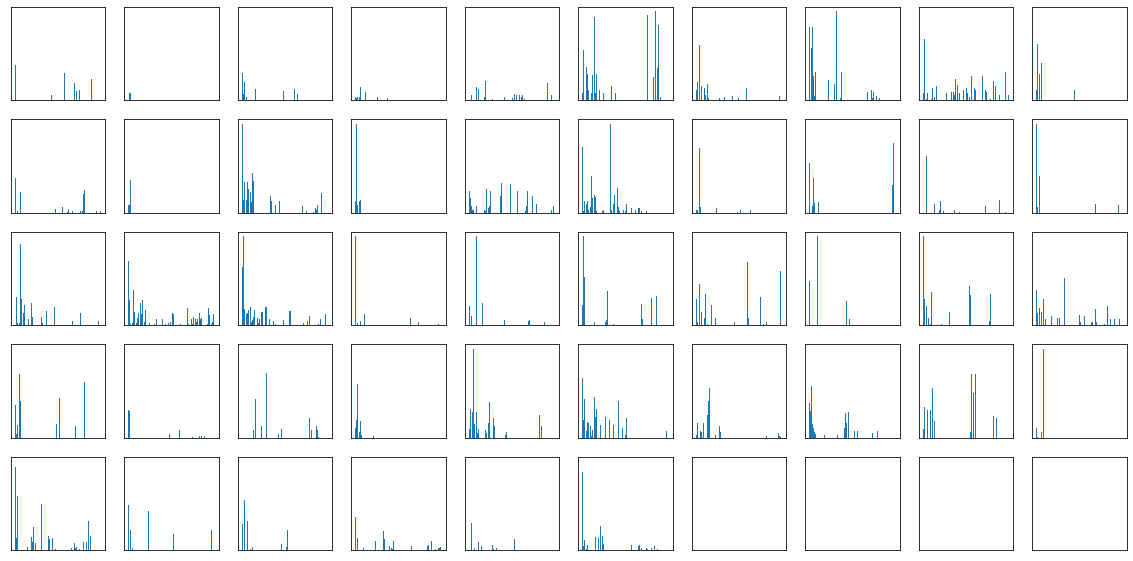

In [63]:
# classe 1
maxplotNumber = 46
count = 0
subplot_args = {'nrows': 5, 'ncols':10, 'figsize':(20,10),
                'subplot_kw': {'xticks':[],'yticks':[]}}
f, ax = plt.subplots(**subplot_args)
for i in range (users.shape[0]):
  if (count != maxplotNumber):
    if (Y_decomposed_complex[i]==3):
      ax.flatten()[count].bar(range(0,center_temporal.shape[1]),absolute_log_counts[i,:366])
      count = count +1
  else:
    break

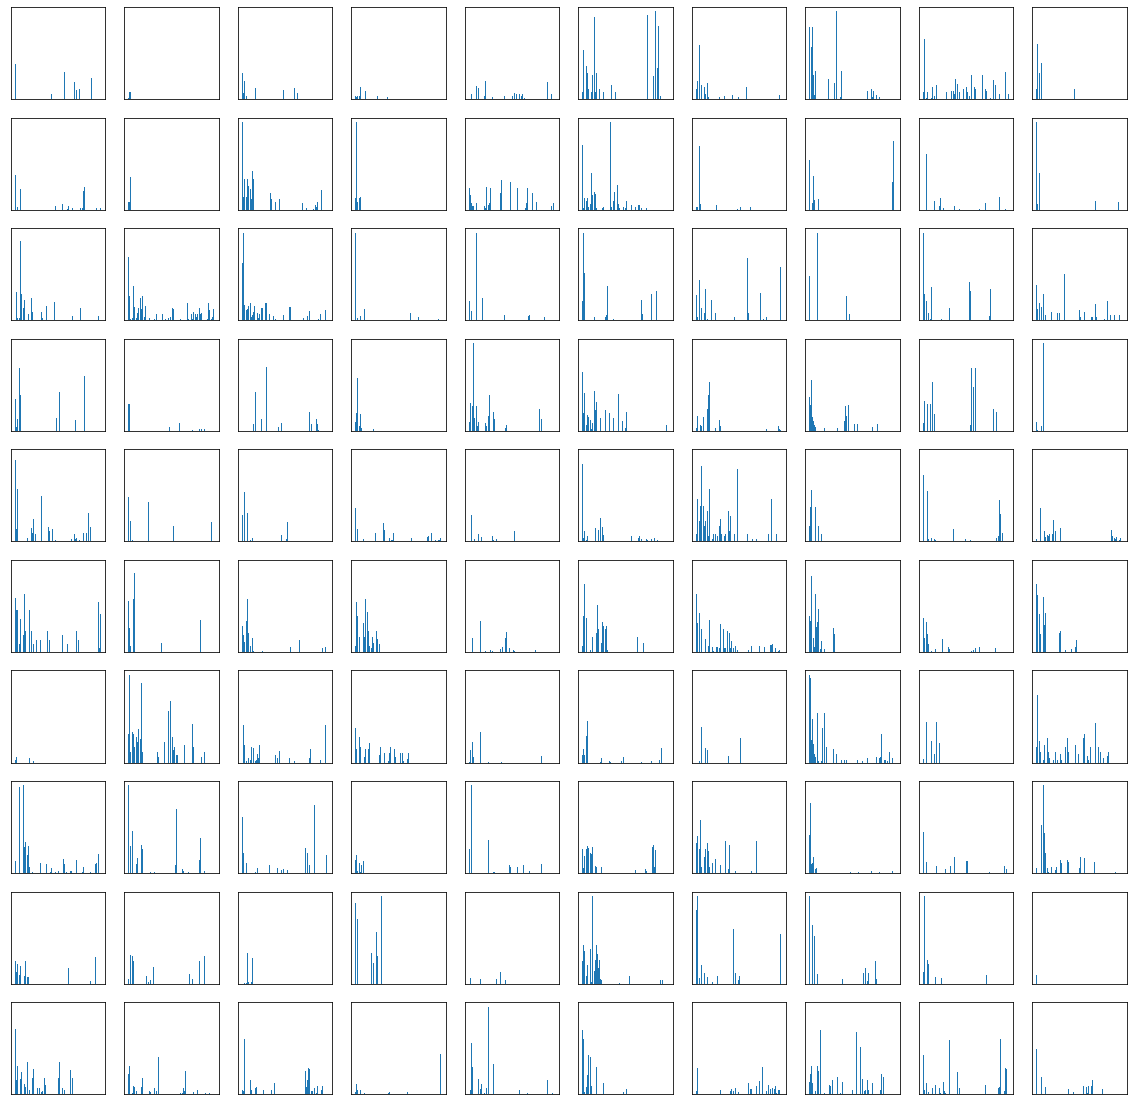

In [64]:
# classe 3
maxplotNumber = 100
count = 0
subplot_args = {'nrows': 10, 'ncols':10, 'figsize':(20,20),
                'subplot_kw': {'xticks':[],'yticks':[]}}
f, ax = plt.subplots(**subplot_args)
for i in range (users.shape[0]):
  if (count != maxplotNumber):
    if (Y_decomposed_complex[i]==3):
      ax.flatten()[count].bar(range(0,center_temporal.shape[1]),absolute_log_counts[i,:366])
      count = count +1
  else:
    break


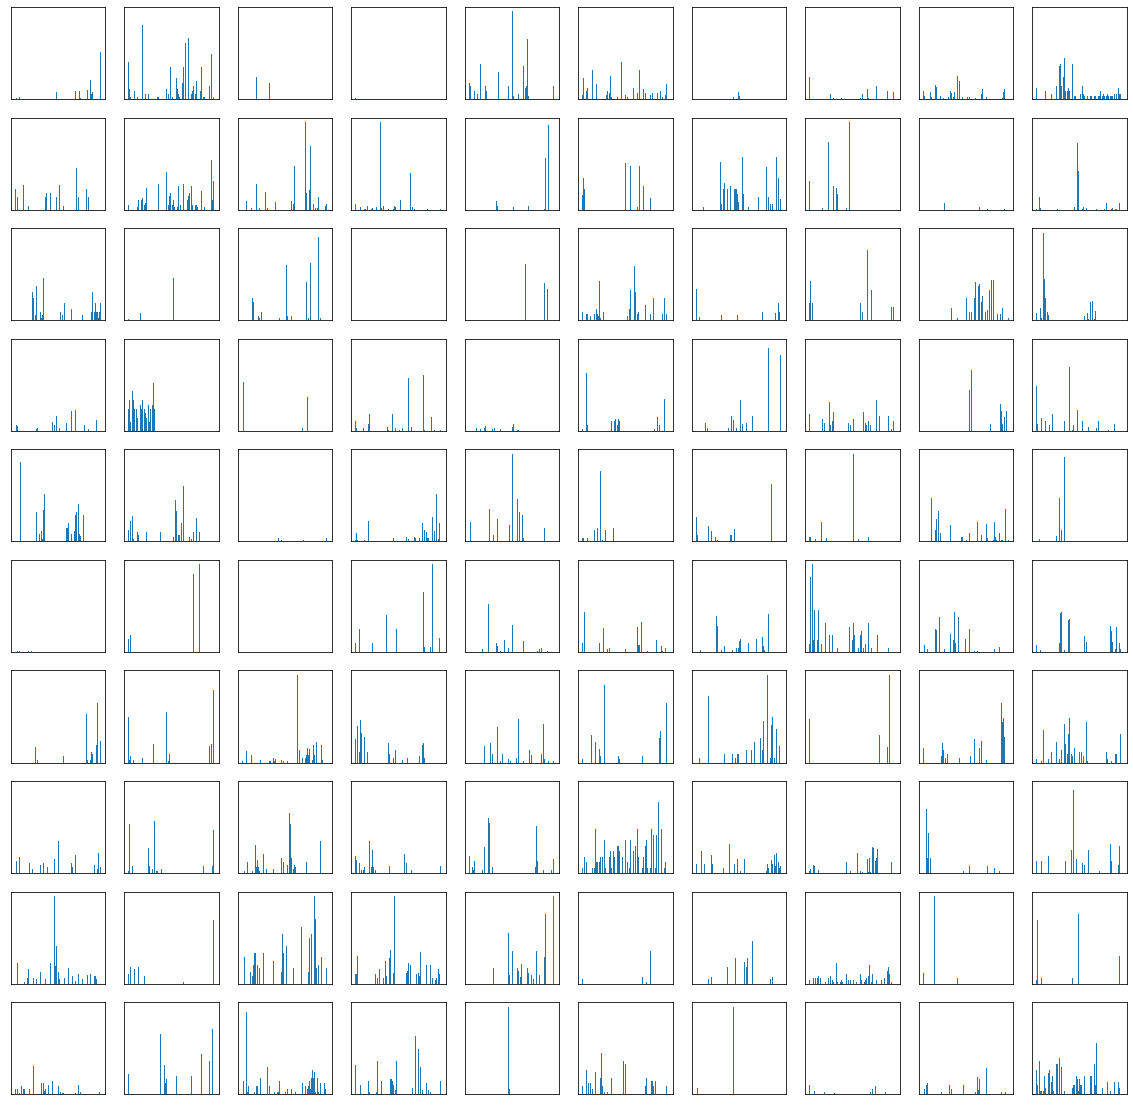

In [65]:
# classe 7
maxplotNumber = 100
count = 0
subplot_args = {'nrows': 10, 'ncols':10, 'figsize':(20,20),
                'subplot_kw': {'xticks':[],'yticks':[]}}
f, ax = plt.subplots(**subplot_args)
for i in range (users.shape[0]):
  if (count != maxplotNumber):
    if (Y_decomposed_complex[i]==7):
      ax.flatten()[count].bar(range(0,center_temporal.shape[1]),absolute_log_counts[i,:366])
      count = count +1
  else:
    break